<h1 style="color:navy;">Fault Detection in Gas Turbine Engines using Sensor Data</h1>
<p><strong>By: Garey Salinas</strong></p>

## Overview

This notebook analyzes sensor data from industrial gas turbine engines to detect faults and support predictive maintenance. The main goal is to develop machine learning models that can accurately classify failures in gas compressors—critical for midstream pipeline operations where turbines drive compression systems.

## Dataset

- **Source:** Gas Turbine Engine Fault Detection Dataset (Kaggle)
- **Contents:** Sensor readings such as temperatures, pressures, rotational speeds, and a labeled fault indicator (0 = normal, 1 = fault).
- **Structure:** 1,386 rows × 10 columns, all continuous features except the binary fault label.

## Objectives

- Build classification models to detect and classify faults.
- Engineer features (e.g., pressure ratios, temperature differentials, time-based deltas).
- Apply outlier detection to identify sensor anomalies.
- Use time-series segmentation to capture operational patterns.

## Techniques and Tools

**Machine Learning Models:**
- Random Forest
- XGBoost
- Support Vector Machines

**Outlier Detection:**
- Isolation Forest
- DBSCAN

**Time-Series Analysis:**
- Windowing and segmentation
- Trend decomposition (optional for EDA)

**Python Libraries:**
- scikit-learn
- xgboost
- numpy
- pandas
- seaborn
- matplotlib

## Value and Impact

This project aims to:
- Detect mechanical degradation early
- Reduce equipment downtime
- Enhance pipeline safety
- Lower operational costs

## Import Libraries

In [1]:
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')  

## Load Dataset

In [2]:
# Load the dataset
data = pd.read_csv('data/gas_turbine_fault_detection.csv')

data.head()

Temperature (°C)           RPM  Torque (Nm)  Vibrations (mm/s)  \
0        924.835708  15650.870645  3464.645167           1.675087   
1        893.086785  15780.755598  3190.276340           2.042084   
2        932.384427  15016.002075  3401.769251           2.006414   
3        976.151493  14623.291065  3443.024901           2.239914   
4        888.292331  15229.986071  3448.764050           1.865677   

   Power Output (MW)  Fuel Flow Rate (kg/s)  Air Pressure (kPa)  \
0          96.347590               2.265294          146.245460   
1          83.288302               2.755950          166.812134   
2         120.358735               2.574244          133.494161   
3         104.689781               2.497101          140.141635   
4          95.080431               2.763689          109.795667   

   Exhaust Gas Temperature (°C)  Oil Temperature (°C)  Fault  
0                    517.611726             90.530958      0  
1                    500.196460            136.047350      0  
2                    516.272719            124.910039      0  
3                    475.731083            123.298231      1  
4                    546.737163            119.382239      1

## Perform EDA

In [3]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Temperature (°C)              1386 non-null   float64
 1   RPM                           1386 non-null   float64
 2   Torque (Nm)                   1386 non-null   float64
 3   Vibrations (mm/s)             1386 non-null   float64
 4   Power Output (MW)             1386 non-null   float64
 5   Fuel Flow Rate (kg/s)         1386 non-null   float64
 6   Air Pressure (kPa)            1386 non-null   float64
 7   Exhaust Gas Temperature (°C)  1386 non-null   float64
 8   Oil Temperature (°C)          1386 non-null   float64
 9   Fault                         1386 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 108.4 KB


### Column Information

The dataframe has 1,386 rows and 10 columns. All columns are complete with no missing values. The features are mostly continuous floating point numbers, and the target column is Fault (int64), which represents a classification label (e.g., 0 = normal, 1 = fault). We will change the type of variable of column Fault to represent a boolean value.

| Column Name                      | Description                   | Unit/Type      |
|----------------------------------|-------------------------------|----------------|
| Temperature (°C)                 | Turbine temperature           | °C (float)     |
| RPM                              | Rotations per minute          | RPM (float)    |
| Torque (Nm)                      | Torque                        | Nm (float)     |
| Vibrations (mm/s)                | Vibration level               | mm/s (float)   |
| Power Output (MW)                | Power output                  | MW (float)     |
| Fuel Flow Rate (kg/s)            | Fuel flow rate                | kg/s (float)   |
| Air Pressure (kPa)               | Air pressure                  | kPa (float)    |
| Exhaust Gas Temperature (°C)     | Exhaust gas temperature       | °C (float)     |
| Oil Temperature (°C)             | Oil temperature               | °C (float)     |
| Fault (target)                   | Fault status (0/1)            | int (0 or 1)   |

In [4]:
df.describe()

Temperature (°C)           RPM  Torque (Nm)  Vibrations (mm/s)  \
count       1386.000000   1386.000000  1386.000000        1386.000000   
mean         901.623932  15022.591497  3494.764285           1.978964   
std           49.381498    490.048647   203.828153           0.494025   
min          737.936633  13490.243922  2901.772806           0.411648   
25%          868.117411  14688.039309  3355.445978           1.658465   
50%          901.964879  15016.737353  3490.639925           1.989549   
75%          932.692748  15346.057959  3627.482077           2.322288   
max         1092.636575  16596.553784  4285.247541           3.556455   

       Power Output (MW)  Fuel Flow Rate (kg/s)  Air Pressure (kPa)  \
count        1386.000000            1386.000000         1386.000000   
mean           99.497230               2.505591          150.320568   
std            10.309697               0.316582           19.430192   
min            71.004861               1.349003           93.961769   
25%            92.387182               2.296762          137.688214   
50%            99.378143               2.500537          150.464896   
75%           106.454488               2.724751          163.130104   
max           135.290552               3.513215          213.155426   

       Exhaust Gas Temperature (°C)  Oil Temperature (°C)        Fault  
count                   1386.000000           1386.000000  1386.000000  
mean                     498.865296            120.061923     0.306638  
std                       28.793950             10.005188     0.461264  
min                      382.327992             86.244209     0.000000  
25%                      479.238499            113.652494     0.000000  
50%                      498.865627            119.968056     0.000000  
75%                      518.337798            126.570199     1.000000  
max                      587.423276            153.777682     1.000000

### Distribution Breakdown of Each Column

- **Temperature (°C)**
  - Mean: 901.62, Std: 49.38
  - Min: 737.94, 25%: 868.12, Median: 901.96, 75%: 932.69, Max: 1092.64
  - Most values are centered around 900°C, moderate spread.

- **RPM**
  - Mean: 15022.59, Std: 490.05
  - Min: 13490.24, 25%: 14688.04, Median: 15016.74, 75%: 15346.06, Max: 16596.55
  - Tightly clustered around 15,000 RPM.

- **Torque (Nm)**
  - Mean: 3494.76, Std: 203.83
  - Min: 2901.77, 25%: 3355.45, Median: 3490.64, 75%: 3627.48, Max: 4285.25
  - Most values near 3,500 Nm.

- **Vibrations (mm/s)**
  - Mean: 1.98, Std: 0.49
  - Min: 0.41, 25%: 1.66, Median: 1.99, 75%: 2.32, Max: 3.56
  - Slight right skew, most between 1.6 and 2.3 mm/s.

- **Power Output (MW)**
  - Mean: 99.50, Std: 10.31
  - Min: 71.00, 25%: 92.39, Median: 99.38, 75%: 106.45, Max: 135.29
  - Most values close to 100 MW.

- **Fuel Flow Rate (kg/s)**
  - Mean: 2.51, Std: 0.32
  - Min: 1.35, 25%: 2.30, Median: 2.50, 75%: 2.72, Max: 3.51
  - Most between 2.3 and 2.7 kg/s.

- **Air Pressure (kPa)**
  - Mean: 150.32, Std: 19.43
  - Min: 93.96, 25%: 137.69, Median: 150.46, 75%: 163.13, Max: 213.16
  - Centered around 150 kPa.

- **Exhaust Gas Temperature (°C)**
  - Mean: 498.87, Std: 28.79
  - Min: 382.33, 25%: 479.24, Median: 498.87, 75%: 518.34, Max: 587.42
  - Most values near 500°C.

- **Oil Temperature (°C)**
  - Mean: 120.06, Std: 10.01
  - Min: 86.24, 25%: 113.65, Median: 119.97, 75%: 126.57, Max: 153.78
  - Most between 113.65 and 126.57°C.

- **Fault (target)**
  - Mean: 0.31, Std: 0.46
  - Min: 0, 25%: 0, Median: 0, 75%: 1, Max: 1
  - 31% faults (1), 69% normal (0); imbalanced data.

### Check for Missing Values

In [5]:
# Check for missing values
df.isnull().sum()

Temperature (°C)                0
RPM                             0
Torque (Nm)                     0
Vibrations (mm/s)               0
Power Output (MW)               0
Fuel Flow Rate (kg/s)           0
Air Pressure (kPa)              0
Exhaust Gas Temperature (°C)    0
Oil Temperature (°C)            0
Fault                           0
dtype: int64

### Check for Duplicate Rows

In [6]:
# Perform basic data cleaning
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
# Remove duplicate rows if any

Number of duplicate rows: 0


### Change Column Names

In [7]:
# Change the column names to lowercase
df.columns = df.columns.str.lower()
# Rename columns for easier access
df.rename(columns={
    'temperature (°c)': 'temperature',
    'torque (nm)': 'torque',
    'vibrations (mm/s)': 'vibrations',
    'power output (mw)': 'power_output',
    'fuel flow rate (kg/s)': 'fuel_flow_rate',
    'air pressure (kpa)': 'air_pressure',
    'exhaust gas temperature (°c)': 'exhaust_gas_temperature',
    'oil temperature (°c)': 'oil_temperature'
}, inplace=True)
# Check the data types of the columns
df.dtypes


temperature                float64
rpm                        float64
torque                     float64
vibrations                 float64
power_output               float64
fuel_flow_rate             float64
air_pressure               float64
exhaust_gas_temperature    float64
oil_temperature            float64
fault                        int64
dtype: object

### Change Fault Type to Boolean

In [8]:
# Convert Fault column to boolean
df['fault'] = df['fault'].astype(bool)

### Distribution of Faults

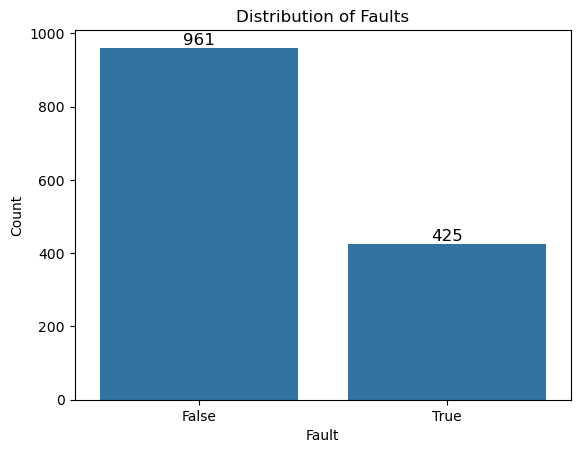

In [9]:
# Visualize the distribution of the target variable with value counts on bars
ax = sns.countplot(x='fault', data=df)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')
plt.title('Distribution of Faults')
plt.xlabel('Fault')
plt.ylabel('Count')
plt.show()

## Distribution of Each Feature

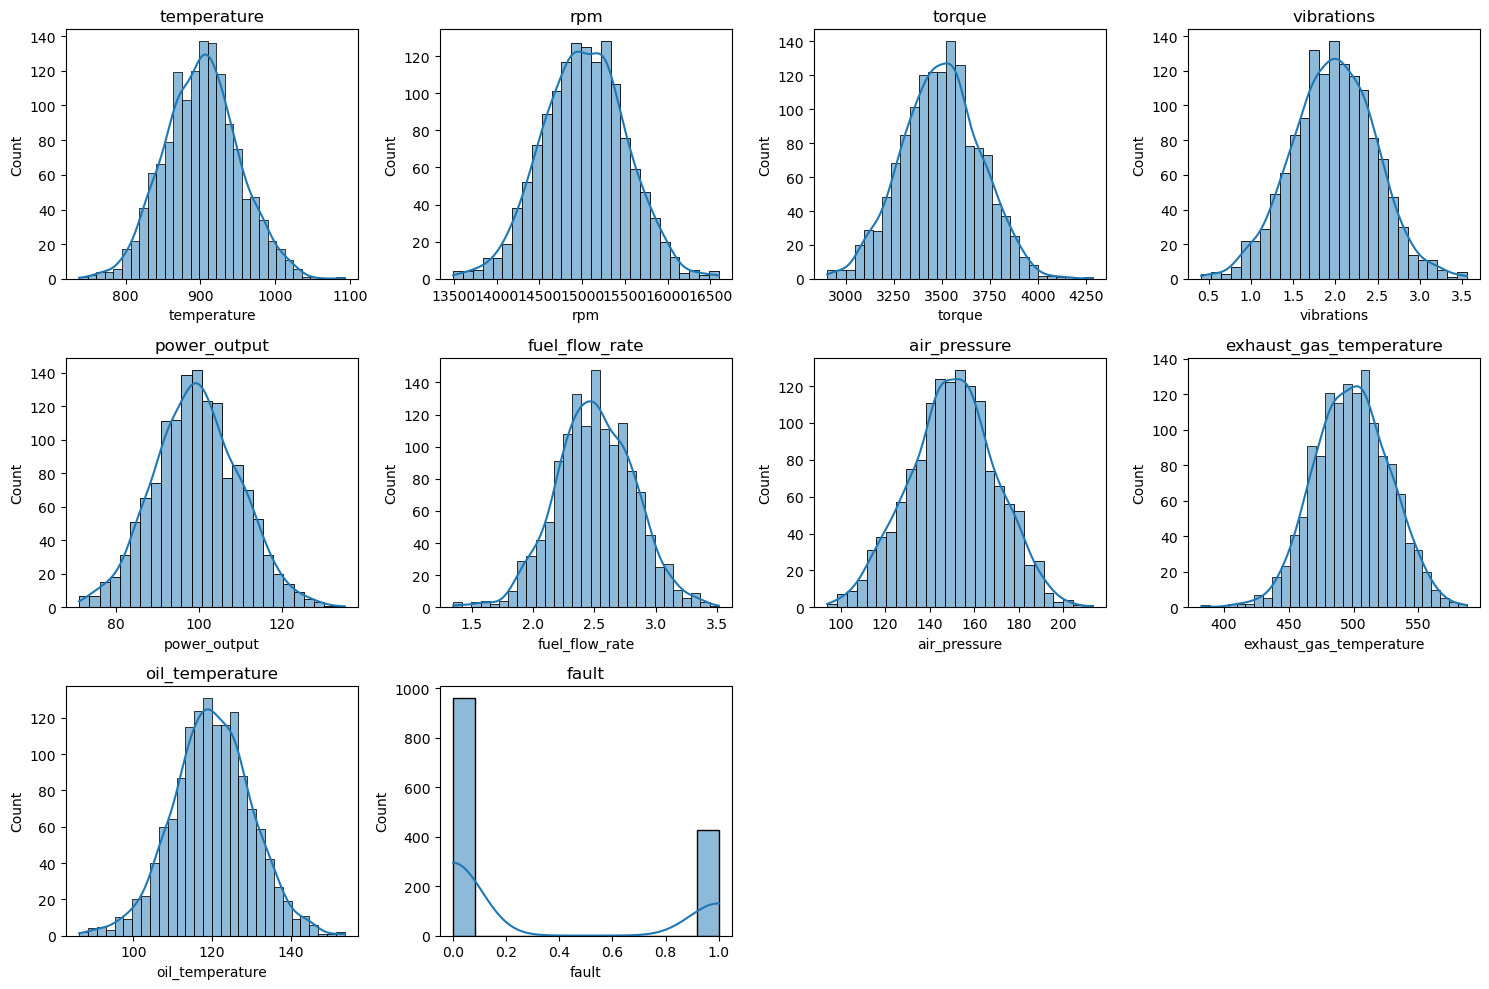

In [10]:
# Perfrom Exploratory Data Analysis (EDA)
# Visualize the distribution of each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)
plt.tight_layout()

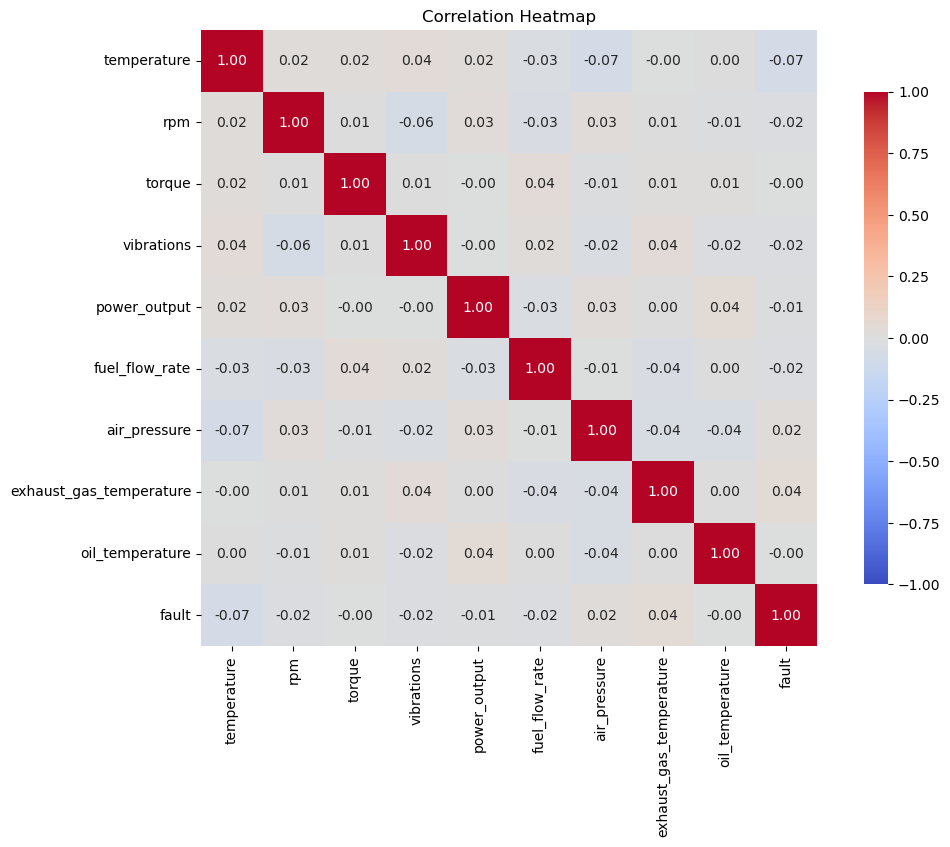

In [11]:
# Create a heatmap to visualize the correlation between features with a better color palette and visible diagonal
plt.figure(figsize=(12, 8))
corr = df.corr()
#mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # Mask only the upper triangle, keep diagonal

sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',  # or 'crest', 'YlGnBu', etc.
    #mask=mask,
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap')
plt.show()


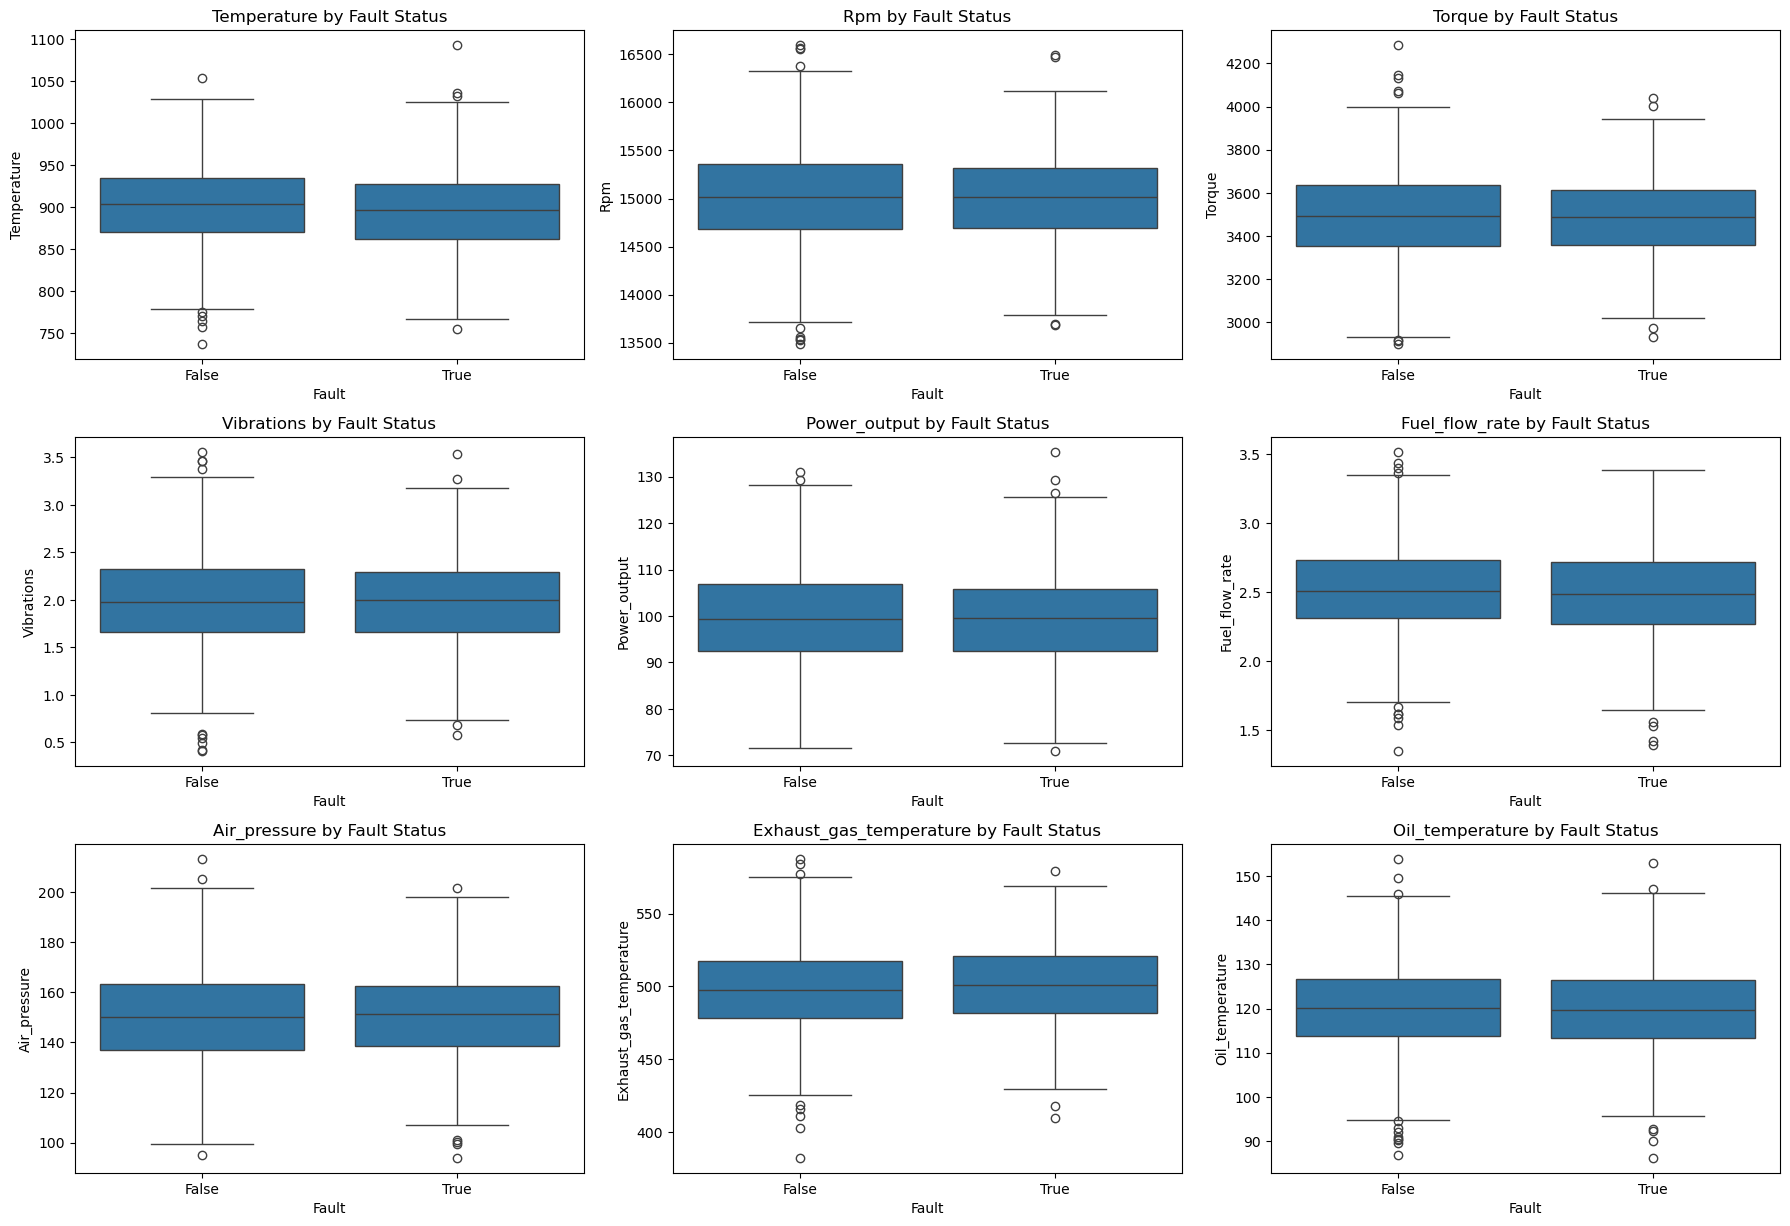

In [12]:
# Create boxplots for each feature grouped by the target variable 'fault'
features = [col for col in df.columns if col not in ['fault']]

plt.figure(figsize=(18, 16))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i + 1)  # Adjusted to a 4x3 grid to fit all 10 features
    sns.boxplot(x='fault', y=feature, data=df)
    plt.title(f'{feature.capitalize()} by Fault Status')
    plt.xlabel('Fault')
    plt.ylabel(feature.capitalize())
plt.tight_layout()
plt.show()

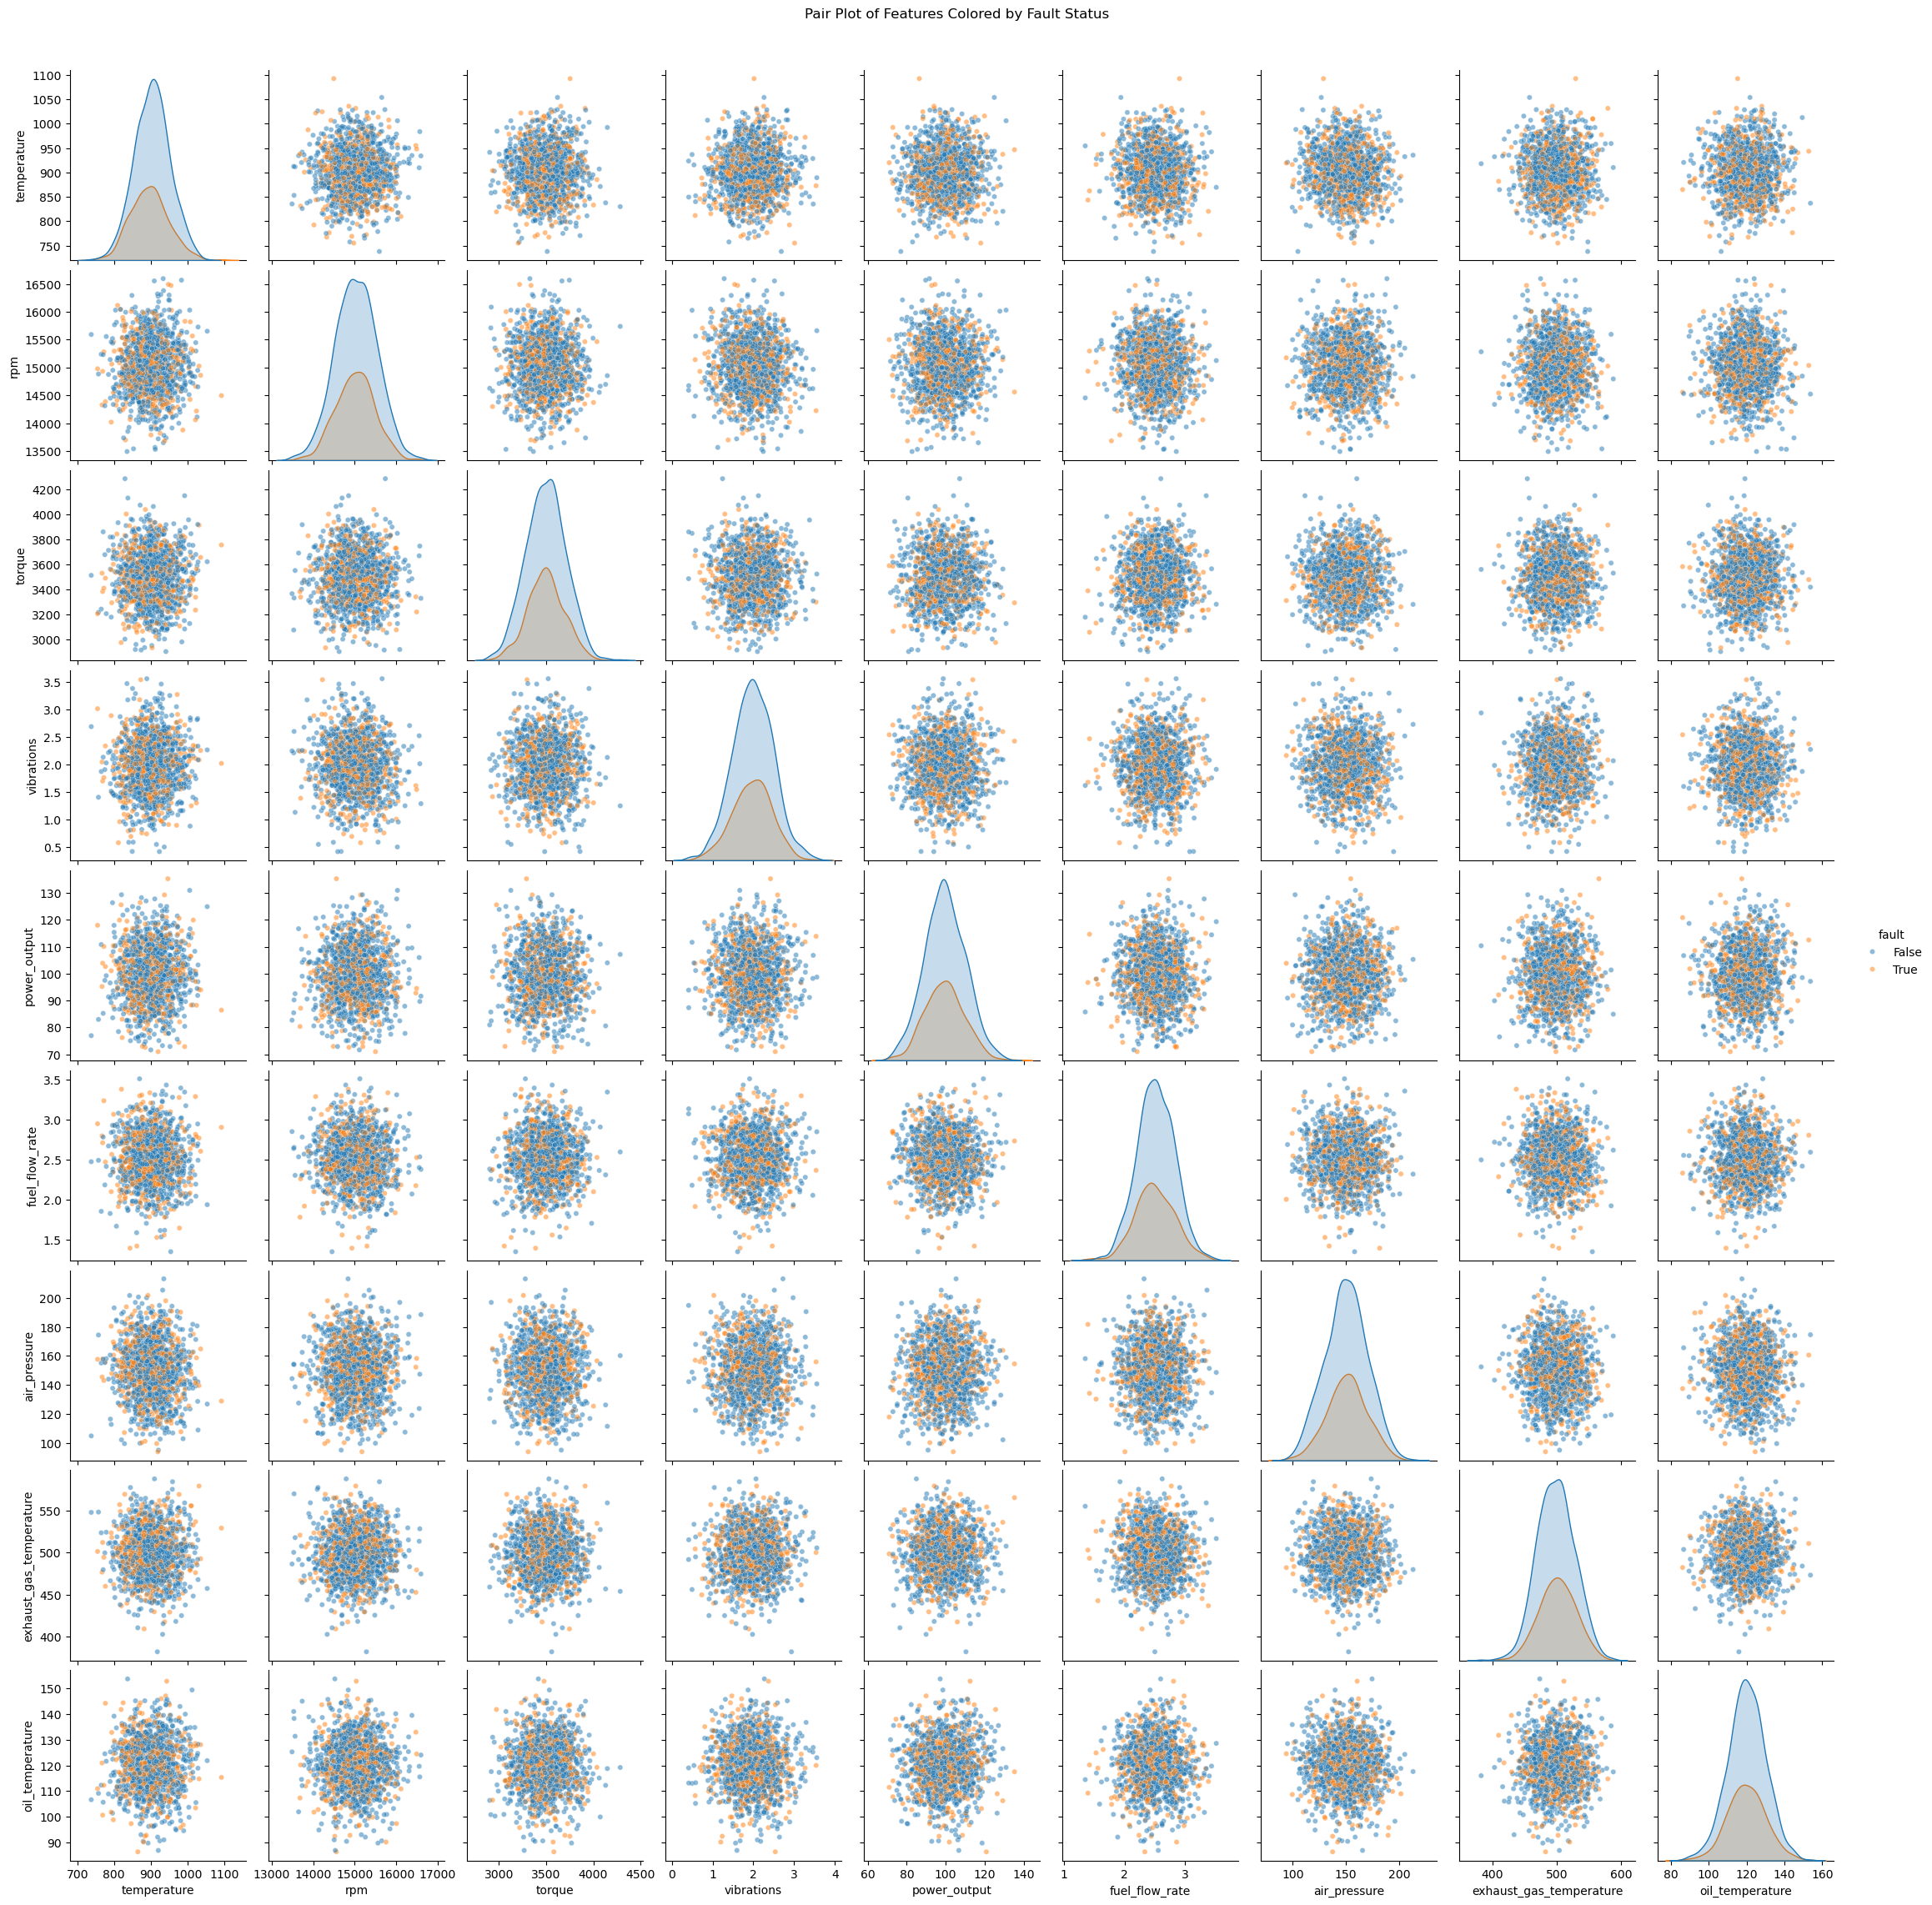

In [13]:
# Create pair plots to visualize relationships between features colored by fault status
sns.pairplot(df, hue='fault', diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle('Pair Plot of Features Colored by Fault Status', y=1.02)
plt.show()

The correlation heatmap displays the pairwise correlation coefficients between all features in the dataset. Most features show very weak correlations with each other and with the target variable (fault), as indicated by values close to zero. No strong linear relationships are observed between the sensor readings, and the fault variable does not have a strong correlation with any single feature.

In [14]:
# Perform feature engineering
# Create a new feature: Power to Torque Ratio
df['power_torque_ratio'] = df['power_output'] / df['torque']
df['power_torque_ratio'].describe()

count    1386.000000
mean        0.028568
std         0.003424
min         0.018724
25%         0.026216
50%         0.028356
75%         0.030661
max         0.042236
Name: power_torque_ratio, dtype: float64

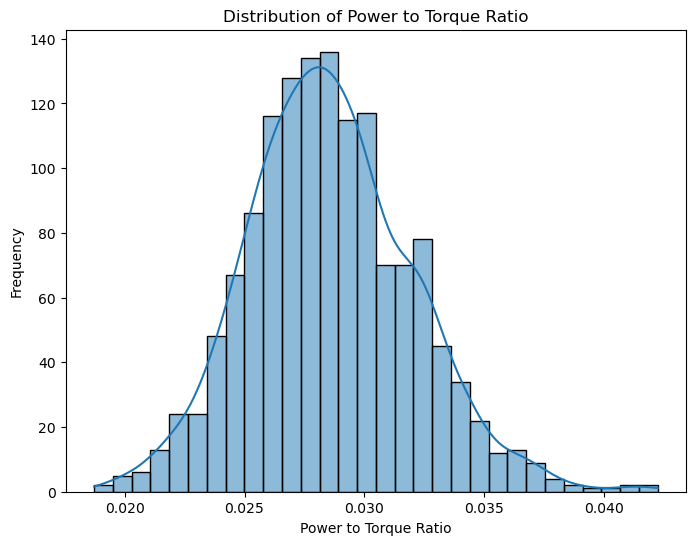

In [15]:
# Show distribution of the new feature
plt.figure(figsize=(8, 6))
sns.histplot(df['power_torque_ratio'], kde=True)
plt.title('Distribution of Power to Torque Ratio')
plt.xlabel('Power to Torque Ratio')
plt.ylabel('Frequency')
plt.show()

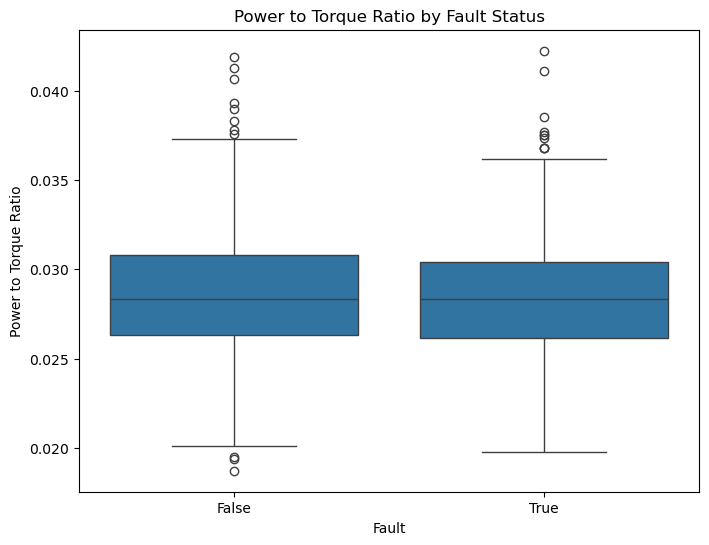

In [16]:
# Visulize the relationship between the new feature and the target variable
plt.figure(figsize=(8, 6))
sns.boxplot(x='fault', y='power_torque_ratio', data=df)
plt.title('Power to Torque Ratio by Fault Status')
plt.xlabel('Fault')
plt.ylabel('Power to Torque Ratio')
plt.show()

The boxplot above compares the distribution of the Power to Torque Ratio between normal (Fault = False) and fault (Fault = True) conditions. Both groups have similar median values and interquartile ranges, indicating that the Power to Torque Ratio does not differ significantly between fault and non-fault cases. There are some outliers in both groups, but overall, this feature alone does not provide strong separation between the two classes. This suggests that additional features or combinations of features may be needed to effectively distinguish between fault and normal states.